In [1]:
#import sys
#sys.path.remove('/net/gpfs-amarolab/cseitz/from_jam/projects/phage/2_simulation_files/prody')
#!{sys.executable} -m pip uninstall prody
#!{sys.executable} -m pip install prody --user
#sys.path.append('/home/cseitz/.local/bin')
#!{sys.executable} -m pip install ./ProDy --user

In [2]:
#pip install -U prody

In [67]:
from prody import *
from matplotlib.pylab import *
import itertools
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.weight':'medium', 
         'xtick.major.size':8,
         'ytick.major.size':8}
pylab.rcParams.update(params)
print(prody)
ion() # turn interactive mode on

<module 'prody' from '/home/cseitz/.local/lib/python3.7/site-packages/prody/__init__.py'>


load the phage protein sheet, and select only the alpha carbons. I am going to try making GNM and ANM with all atoms and only with alpha carbons

In [28]:
glycosylated = parsePDB('glycosylated_rep1.pdb')
glycosylated
gall = glycosylated.select('all')
gall
galphas = glycosylated.select('calpha')
galphas

unglycosylated = parsePDB('unglycosylated_rep1.pdb')
unglycosylated
ugall = unglycosylated.select('all')
ugall
ugalphas = unglycosylated.select('calpha')
ugalphas

@> 30101 atoms and 1 coordinate set(s) were parsed in 0.24s.
@> 28328 atoms and 1 coordinate set(s) were parsed in 0.22s.


<Selection: 'calpha' from unglycosylated_rep1 (1876 atoms)>

instantiate a Gaussian network matrix (GNM) instance

In [29]:
gnmgall = GNM('Glycosylatedall')
gnmgalphas = GNM('Glycosylatedalphas')

gnmugall = GNM('Unglycosylatedall')
gnmugalphas = GNM('Unglycosylatedalphas')

The Kirchoff matrix, also known as a Laplacian matrix, is simply the matrix representation of a graph. To do GNM we need to create a Kirchoff adjacency matrix for the for a protein defining the proximity of residues in space. Inverting this matrix gives us the cross correlations of the atomic fluctuations.

In [31]:
gnmgall.buildKirchhoff(gall)
gnmgalphas.buildKirchhoff(galphas)

gnmugall.buildKirchhoff(ugall)
gnmugalphas.buildKirchhoff(ugalphas)

@> Kirchhoff was built in 19.31s.
@> Kirchhoff was built in 0.07s.
@> Kirchhoff was built in 17.81s.
@> Kirchhoff was built in 0.07s.


A normal mode of a system is a pattern describing how the system moves sinusoidally and with the same frequency and with fixed phase relation. This function calculates the normal modes from the Kirchoff matrix. In biological terms, the modes describe the dynamics of the system, such as structural changes or atomic motions.

In [32]:
gnmgall.calcModes(n_modes=10, zeros=False, turbo=True)
gnmgalphas.calcModes(n_modes=10, zeros=False, turbo=True)

gnmugall.calcModes(n_modes=10, zeros=False, turbo=True)
gnmugalphas.calcModes(n_modes=10, zeros=False, turbo=True)

@> 10 modes were calculated in 4015.76s.
@> 10 modes were calculated in 0.25s.
@> 10 modes were calculated in 2929.89s.
@> 10 modes were calculated in 0.30s.


Calculate the eigenvectors and eigenvalues of the Kirchoff matrix, and round to three decimal places

In [33]:
gnmgall.getEigvecs().round(4)
gnmgalphas.getEigvecs().round(4)

gnmugall.getEigvecs().round(4)
gnmugalphas.getEigvecs().round(4)

array([[ 0.0701, -0.0827, -0.0091, ..., -0.0256,  0.0186,  0.0043],
       [ 0.0701, -0.0827, -0.0091, ..., -0.0256,  0.0186,  0.0043],
       [ 0.0699, -0.0808, -0.0088, ..., -0.0235,  0.0172,  0.0039],
       ...,
       [-0.0102, -0.0009, -0.0171, ..., -0.0035,  0.0002,  0.0744],
       [-0.0102, -0.0007, -0.0163, ..., -0.0039,  0.0002,  0.0787],
       [-0.0101, -0.    , -0.0117, ..., -0.0044,  0.0002,  0.0718]])

In [86]:
print(gnmgall[0].getEigval().round(5))
print(gnmgalphas[0].getEigval().round(5))

print(gnmugall[0].getEigval().round(5))
print(gnmugalphas[0].getEigval().round(5))

0.34959
0.02608
0.35233
0.02612


Here, we see that the eigenvalues for the systems without glycans are slightly higher than for those with glycans. Smaller eigenvalues should mean stiffer systems, so our results say that glycans make the proteins more rigid.

The covariance matrix gives the relation between each pair of elements in a vector. We use the covariance matrix to determine the variance between the system members for each of the modes that are calculated two cells above, rounded to two decimal places.

In [34]:
#gnm.getCovariance().round(2)

gnmgall.getCovariance().round(3)
gnmgalphas.getCovariance().round(3)

gnmugall.getCovariance().round(3)
gnmugalphas.getCovariance().round(3)

array([[ 0.341,  0.341,  0.331, ..., -0.026, -0.026, -0.026],
       [ 0.341,  0.341,  0.331, ..., -0.026, -0.026, -0.026],
       [ 0.331,  0.331,  0.322, ..., -0.026, -0.026, -0.026],
       ...,
       [-0.026, -0.026, -0.026, ...,  0.012,  0.013,  0.012],
       [-0.026, -0.026, -0.026, ...,  0.013,  0.013,  0.012],
       [-0.026, -0.026, -0.026, ...,  0.012,  0.012,  0.012]])

Let's look at the fraction of variance explained by each of the top five modes. The fraction of variance is the ratio along along a mode to the trace of the covariance matrix of the model. Thus the top five modes account for 86% of the total variance. I only created 10 modes so these account for all of the variance.

In [61]:

for mode in gnmgall[:1]:
   ....:     print(calcFractVariance(mode).round(0))
   ....: 

print("the fraction of variance for the first 10 modes in the gall system is:")
for mode in gnmgall[:10]:
   ....:     print(calcFractVariance(mode).round(2))
   ....: 
print("the fraction of variance for the first 10 modes in the galphas system is:")
for mode in gnmgalphas[:10]:
   ....:     print(calcFractVariance(mode).round(2))
   ....: 
print("the fraction of variance for the first 10 modes in the ugall system is:")
for mode in gnmugall[:10]:
   ....:     print(calcFractVariance(mode).round(2))
   ....: 
print("the fraction of variance for the first 10 modes in the ugalphas system is:")
for mode in gnmugalphas[:10]:
   ....:     print(calcFractVariance(mode).round(2))
   ....: 

1.0
the fraction of variance for the first 10 modes in the gall system is:
0.58
0.09
0.08
0.05
0.05
0.04
0.03
0.03
0.03
0.02
the fraction of variance for the first 10 modes in the galphas system is:
0.63
0.08
0.06
0.06
0.03
0.03
0.03
0.03
0.02
0.02
the fraction of variance for the first 10 modes in the ugall system is:
0.66
0.08
0.05
0.05
0.03
0.03
0.03
0.02
0.02
0.02
the fraction of variance for the first 10 modes in the ugalphas system is:
0.63
0.08
0.06
0.06
0.03
0.03
0.03
0.03
0.02
0.02


Intriguingly, we can figure out what percentage of the atoms are involved in that mode's motion. If a mode has a collectivity score of 0.6, that means that 60% of the atoms are involved in that mode's motion. Here we are plotting the collectivity score for the first five modes. The collectivity is defined by eq. 5 from "Collective protein dynamics and nuclear spin relaxation" by Rafael Brüschweiler, J. Chem. Phys. 1995

In [65]:
print(calcCollectivity(gnmgall[:5]))
print(calcCollectivity(gnmgalphas[:5]))

print(calcCollectivity(gnmugall[:5]))
print(calcCollectivity(gnmugalphas[:5]))

[0.33693823 0.18450637 0.01627734 0.38206813 0.44580831]
[0.28503252 0.20255761 0.4421695  0.52385825 0.2756594 ]
[0.2931127  0.16898943 0.56837268 0.58968398 0.07283829]
[0.28550021 0.2038629  0.44858416 0.52889897 0.29340629]


This is a simple histogram showing how much variance each of the 10 modes contributes to the overall variance.

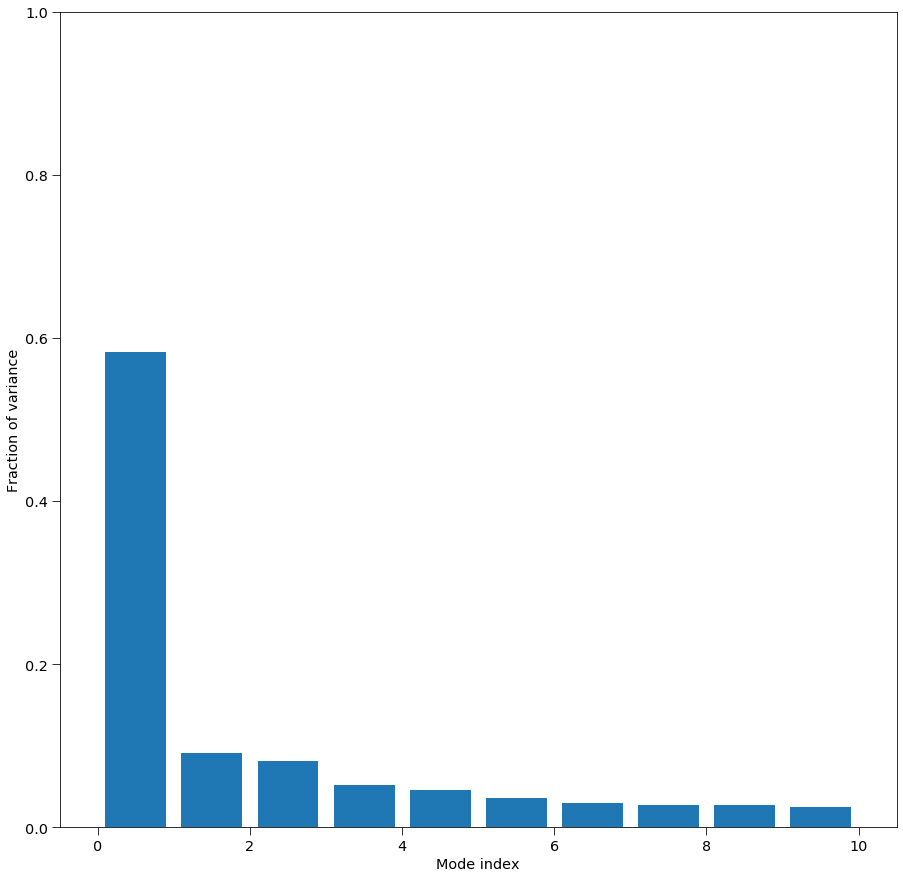

In [75]:
showFractVars(gnmgall)
plt.savefig('./fractvarsgall.png')

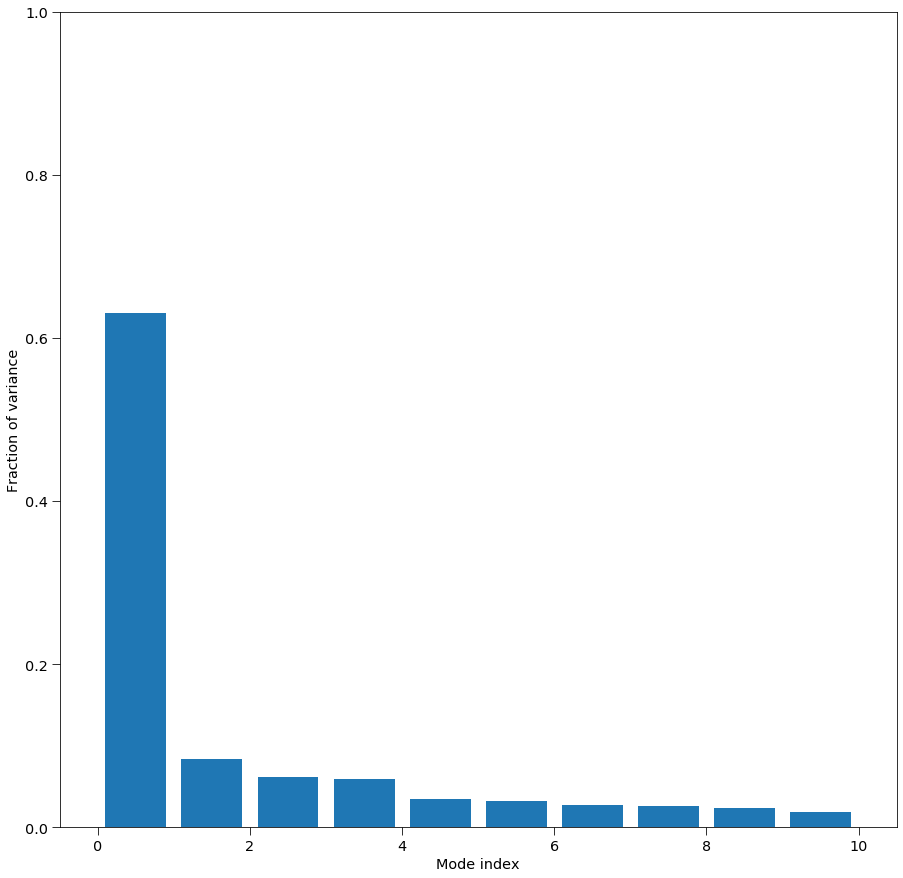

In [71]:
showFractVars(gnmgalphas)
plt.savefig('./fractvarsgalphas.png')

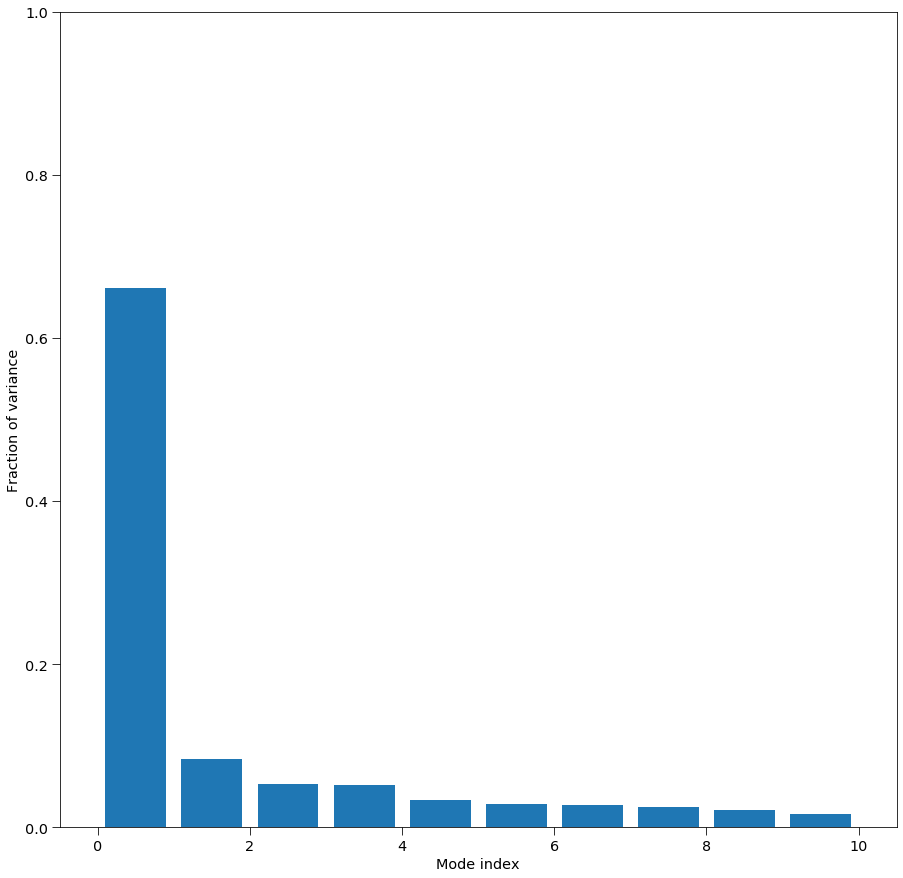

In [72]:
showFractVars(gnmugall)
plt.savefig('./fractvarsugall.png')

This is a simple graph showing how many modes you need to take to capture a certain amount of variance. For example, taking 5 modes captures 86% of the total variance.

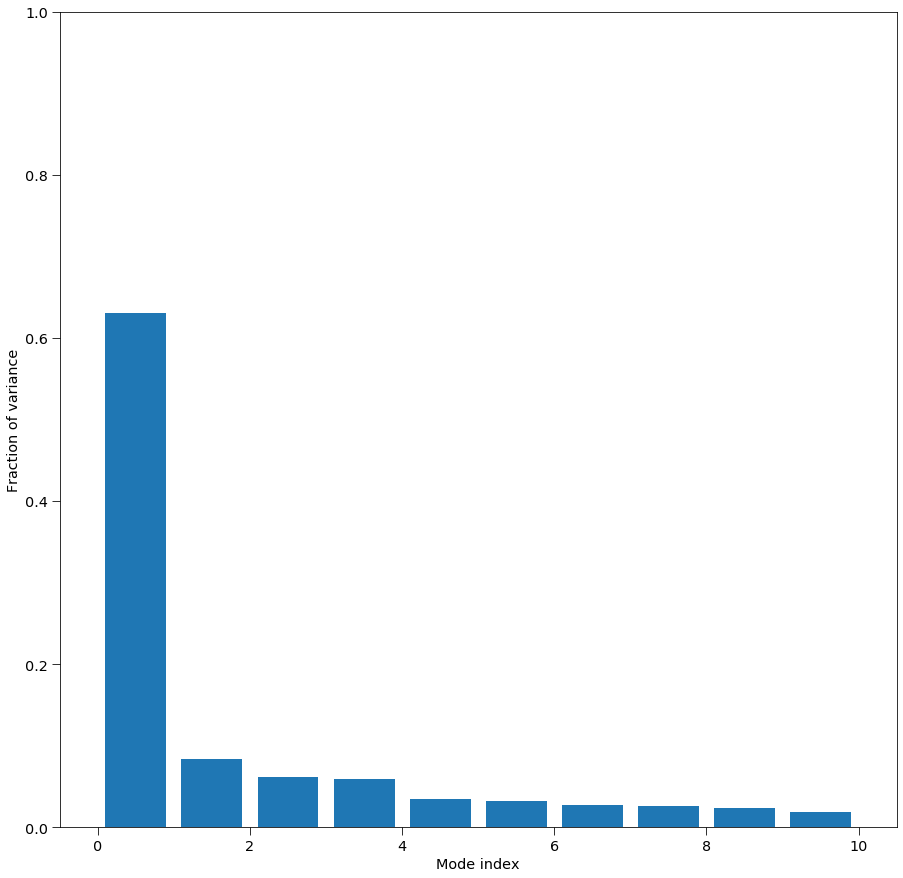

In [73]:
showFractVars(gnmugalphas)
plt.savefig('./fractvarsugalphas.png')

# ANM section

Here we calculate the ANM modes. This takes about 5 hours.

In [96]:
#I need to see if the eigenvalues are identical; if they are, it must be because these coords are identical
print(coordsgalpha)
print(coordsugalpha)

[[ -7.264  20.904 -22.285]
 [-10.823  22.066 -21.213]
 [-13.598  19.661 -19.995]
 ...
 [ 22.331 -10.402 136.915]
 [ 23.89   -7.578 134.897]
 [ 25.886  -7.52  132.704]]
[[ -7.264  20.904 -22.285]
 [-10.823  22.066 -21.213]
 [-13.598  19.661 -19.995]
 ...
 [ 22.331 -10.402 136.915]
 [ 23.89   -7.578 134.897]
 [ 25.886  -7.52  132.704]]


In [ ]:
glycosylated = parsePDB('glycosylated_rep1.pdb')
glycosylated
gall = glycosylated.select('all')
gall
galphas = glycosylated.select('calpha')
galphas

unglycosylated = parsePDB('unglycosylated_rep1.pdb')
unglycosylated
ugall = unglycosylated.select('all')
ugall
ugalphas = unglycosylated.select('calpha')
ugalphas

In [ ]:
gnmgall = GNM('Glycosylatedall')
gnmgalphas = GNM('Glycosylatedalphas')

gnmugall = GNM('Unglycosylatedall')
gnmugalphas = GNM('Unglycosylatedalphas')

In [ ]:
gnmgall.buildKirchhoff(gall)
gnmgalphas.buildKirchhoff(galphas)

gnmugall.buildKirchhoff(ugall)
gnmugalphas.buildKirchhoff(ugalphas)

In [3]:
#anm = ANM('Phage')
#anm.buildHessian(calphas)
#anm.calcModes(n_modes=10, zeros=False, turbo=True)
#coords = getCoords(calphas)

@> Hessian was built in 57.42s.
@> 10 modes were calculated in 18070.41s.


In [94]:
#coordsgall = glycosylated.getCoords()
#coordsgalpha = getCoords(calphas)

#coordsugall = unglycosylated.getCoords()
#coordsugalpha = getCoords(calphas)

In [100]:
anmgall = ANM('Glycosylatedall')
#anmgall.buildHessian(coordsgall)
anmgall.buildHessian(gall)
anmgall.calcModes(n_modes=10, zeros=False, turbo=True)
#coords = getCoords(all)
anmgalphas = ANM('Glycosylatedalphas')
#anmgalphas.buildHessian(coordsgalpha)
anmgalphas.buildHessian(galphas)
anmgalphas.calcModes(n_modes=10, zeros=False, turbo=True)
#coords = getCoords(calphas)

anmugall = ANM('Unglycosylatedall')
#anmugall.buildHessian(coordsgall)
anmugall.buildHessian(ugall)
anmugall.calcModes(n_modes=10, zeros=False, turbo=True)
#coords = getCoords(all)
anmugalphas = ANM('Unglycosylatedalphas')
#anmugalphas.buildHessian(coordsgalpha)
anmugalphas.buildHessian(ugalphas)
anmugalphas.calcModes(n_modes=10, zeros=False, turbo=True)
#coords = getCoords(calphas)

@> Hessian was built in 248.07s.
@> 10 modes were calculated in 41584.83s.
@> Hessian was built in 1.04s.
@> 10 modes were calculated in 8.86s.
@> Hessian was built in 219.42s.
@> 10 modes were calculated in 35407.98s.
@> Hessian was built in 1.09s.
@> 10 modes were calculated in 12.17s.


In [101]:
print(anmgall[0].getEigval().round(5))
print(anmgalphas[0].getEigval().round(5))

print(anmugall[0].getEigval().round(5))
print(anmugalphas[0].getEigval().round(5))

0.02609
0.00114
0.02281
0.00114
